#### This notebook aims to predict total sales using advanced models instead of basic ARIMA as used in [the previous notebook](./sales_prediction.ipynb) and uses the same data set

##### This uses a LightGBM model.

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [3]:
# Import dataset
df = pd.read_csv("../data/retail_store_inventory.csv")

# Display basic info
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [4]:
# Check for null values
df.isnull().sum()

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

Great. No null values here, we can go ahead and perform our feature engineering (this is necessary due to the kind of model we are using here)

### Feature engineering

In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [7]:
# Compute total revenue after considering discount
df["Revenue"] = df["Units Sold"] * df["Price"] * (1 - df["Discount"] / 100)

# Aggregate data to daily level
daily_df = df.groupby("Date").agg({
    "Revenue": "sum",
    "Units Sold": "sum",
    "Price": "mean",
    "Discount": "mean",
    "Competitor Pricing": "mean",
    "Holiday/Promotion": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
}).reset_index()

# Rename column to "Total Units Sold"
daily_df.rename(columns={"Units Sold": "TotalUnitsSold"}, inplace=True)

In [8]:
daily_df.head()

,Date,Revenue,TotalUnitsSold,Price,Discount,Competitor Pricing,Holiday/Promotion
0,2022-01-01,772789.6240,14484,57.5157,10.65,58.1831,1
1,2022-01-02,743864.0160,13415,60.6365,9.80,60.2371,0
2,2022-01-03,673213.6870,13681,56.7993,8.85,56.8813,0
3,2022-01-04,635959.5460,14084,52.9930,10.60,52.8153,1
4,2022-01-05,640787.6075,12572,55.9958,10.40,56.0426,0


We lag the features below to give specific trends and spikes to help train the model

In [9]:
# Lag features
# Lag revenue
daily_df["revenue_lag_1"] = daily_df["Revenue"].shift(1)
daily_df["revenue_lag_7"] = daily_df["Revenue"].shift(7)

# Lag units sold
daily_df["units_lag_1"] = daily_df["TotalUnitsSold"].shift(1)
daily_df["units_lag_7"] = daily_df["TotalUnitsSold"].shift(7)


# Rolling features
daily_df["rev_rolling_7_mean"] = daily_df["Revenue"].shift(1).rolling(7).mean()
daily_df["rev_rolling_14_std"] = daily_df["Revenue"].shift(1).rolling(14).std()

daily_df["units_rolling_7_mean"] = daily_df["TotalUnitsSold"].shift(1).rolling(7).mean()
daily_df["units_rolling_14_std"] = daily_df["TotalUnitsSold"].shift(1).rolling(14).std()

We proceed to extract what day of the week it was (eg. Monday or Saturday) and what month it was (eg. November) to give more time sensitivity information to our model

In [10]:
# Extract day of week and month from `Date`
daily_df["dayofweek"] = daily_df["Date"].dt.dayofweek
daily_df["month"] = daily_df["Date"].dt.month

In [11]:
# Drop null data
daily_df.dropna(inplace=True)

Before we proceed to split our data into train-test split, let's explore it some more to visualize some trends

## Visualizations to show basic trends in the data

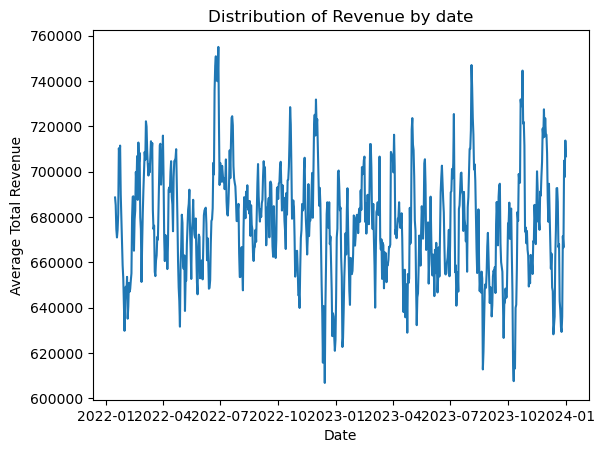

In [12]:
# Visualizing trends in Revenue
plt.plot(daily_df["Date"] ,daily_df["rev_rolling_7_mean"])
plt.xlabel("Date")
plt.ylabel("Average Total Revenue")
plt.title("Distribution of Revenue by date");

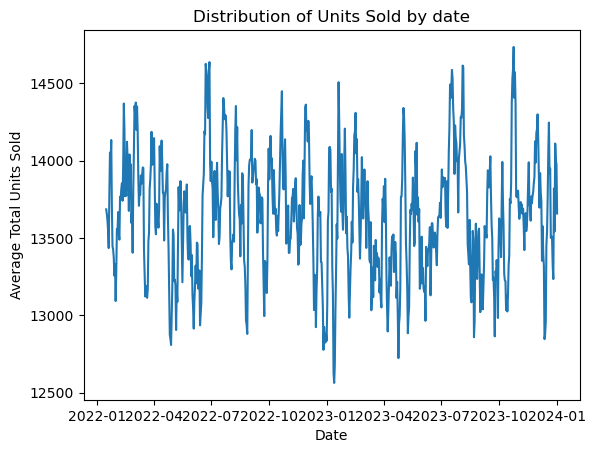

In [13]:
# Visualizing trends in Total Units Sold
plt.plot(daily_df["Date"] ,daily_df["units_rolling_7_mean"])
plt.xlabel("Date")
plt.ylabel("Average Total Units Sold")
plt.title("Distribution of Units Sold by date");

As expected, both the revenue and total units sold seem to have similar trends as per the visualization.

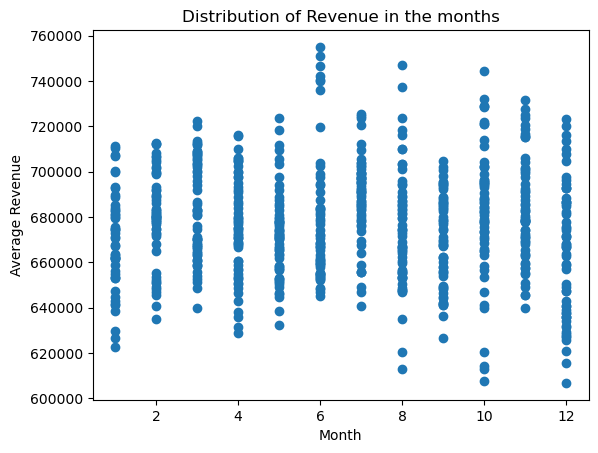

In [14]:
# Visualizing trends in Daily revenue by month
plt.scatter(daily_df["month"] ,daily_df["rev_rolling_7_mean"])
plt.xlabel("Month")
plt.ylabel("Average Revenue")
plt.title("Distribution of Revenue in the months");

It appears that sales generally start a bit lower in the first quarter of the year (comparatively), peaks mid-year (particularly in June) and drops slowly towards the end of the year.

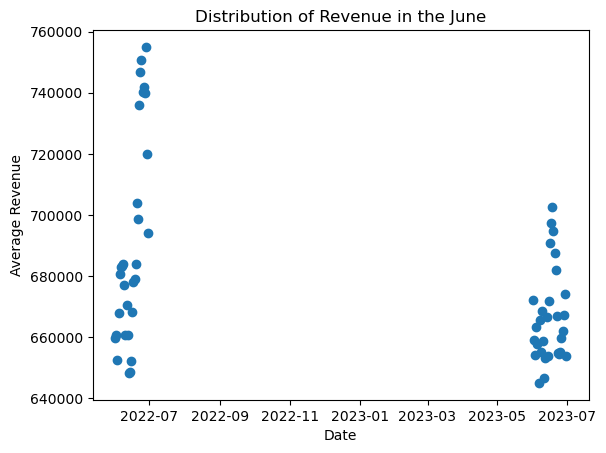

In [15]:
# Reviewing trends in June
june_df = daily_df[daily_df["month"] == 6]
plt.scatter(june_df["Date"] ,june_df["rev_rolling_7_mean"])
plt.xlabel("Date")
plt.ylabel("Average Revenue")
plt.title("Distribution of Revenue in the June");

A clearly visible difference between June 2022 and June 2023. Feel free to explore this into more depth.

### Building model

After basic explorations have been done, we are now ready to begin building our model. It should be noted that, we would be building 2 models; 1 to predict total revenue and another to predict total units sold.

### Feature Selection

In [16]:
# Feature selection
features = [
    "Competitor Pricing", "Holiday/Promotion", "revenue_lag_1",
    "revenue_lag_7", "units_lag_1", "units_lag_7", "rev_rolling_7_mean",
    "rev_rolling_14_std", "units_rolling_7_mean", "units_rolling_14_std",
    "dayofweek", "month", "Price", "Discount"
]

In [29]:
daily_df.set_index("Date", inplace=True)
daily_df.head()

,Revenue,TotalUnitsSold,Price,Discount,Competitor Pricing,Holiday/Promotion,revenue_lag_1,revenue_lag_7,units_lag_1,units_lag_7,rev_rolling_7_mean,rev_rolling_14_std,units_rolling_7_mean,units_rolling_14_std,dayofweek,month
Date,,,,,,,,,,,,,,,,
2022-01-15,681361.3570,13753,54.4455,10.05,54.8672,0,685610.6235,704785.557,13156.0,13958.0,688574.536143,78647.213683,13685.285714,1176.465791,5,1
2022-01-16,781548.5160,15603,53.7904,9.30,53.6888,1,681361.3570,856393.013,13753.0,15896.0,685228.221857,73932.221959,13656.000000,1143.212663,6,1
2022-01-17,648030.4575,13139,55.5517,10.20,56.1736,1,781548.5160,673234.002,15603.0,13607.0,674536.150857,77331.743795,13614.142857,1285.204095,0,1
2022-01-18,751477.7140,14079,57.3770,10.30,57.3647,0,648030.4575,728747.083,13139.0,14866.0,670935.644500,77677.531756,13547.285714,1289.525283,1,1
2022-01-19,665804.4115,14047,52.8248,10.30,53.4382,0,751477.7140,615217.395,14079.0,11622.0,674182.877500,79490.781606,13434.857143,1289.358960,2,1


In [30]:
# Selecting features and target for `Total Units Sold` predictions
X_units = daily_df[features]
y_units = daily_df["TotalUnitsSold"]

In [31]:
# Selecting features and target for `Revenue` predictions
X_revenue = daily_df[features]
y_revenue = daily_df["Revenue"]

### Train test split

A sequential split would be used (rather than a randomized one) due to the data being time series data. An 80-20 split would be used

In [32]:
# Set cut-off
cutoff = int(len(daily_df) * 0.8)

In [33]:
# Perform train test split
X_train_units, X_test_units = X_units[:cutoff], X_units[cutoff:]
y_train_units, y_test_units = y_units[:cutoff], y_units[cutoff:]

X_train_revenue, X_test_revenue = X_revenue[:cutoff], X_revenue[cutoff:]
y_train_revenue, y_test_revenue = y_revenue[:cutoff], y_revenue[cutoff:]

In [60]:
# Train units model
units_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=20,
    min_child_samples=30,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)
units_model.fit(
    X_train_units, y_train_units,
    eval_set=[(X_test_units, y_test_units)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=50
)

c:\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's rmse: 1090.99	valid_0's l2: 1.19026e+06


LGBMRegressor(learning_rate=0.05, max_depth=5, min_child_samples=30,
              n_estimators=1000, num_leaves=20, random_state=42, reg_alpha=1.0,
              reg_lambda=1.0)

In [64]:
# Train revenue model
revenue_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=20,
    min_child_samples=30,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)
revenue_model.fit(
    X_train_revenue, y_train_revenue,
    eval_set=[(X_test_revenue, y_test_revenue)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=50
)

c:\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's rmse: 62158.6	valid_0's l2: 3.86369e+09
[100]	valid_0's rmse: 63043	valid_0's l2: 3.97442e+09


LGBMRegressor(learning_rate=0.05, max_depth=5, min_child_samples=30,
              n_estimators=1000, num_leaves=20, random_state=42, reg_alpha=1.0,
              reg_lambda=1.0)

### Evaluation

In [65]:
# Make units training evaluation
y_train_pred_units = units_model.predict(X_train_units)
training_mae = mean_absolute_error(y_train_units, y_train_pred_units)
training_rmse = np.sqrt(mean_squared_error(y_train_units, y_train_pred_units))

print("Units model training MAE:", training_mae)
print("Units model training RMSE:", training_rmse)

Units model training MAE: 807.3481067853637
Units model training RMSE: 1016.0212161839362


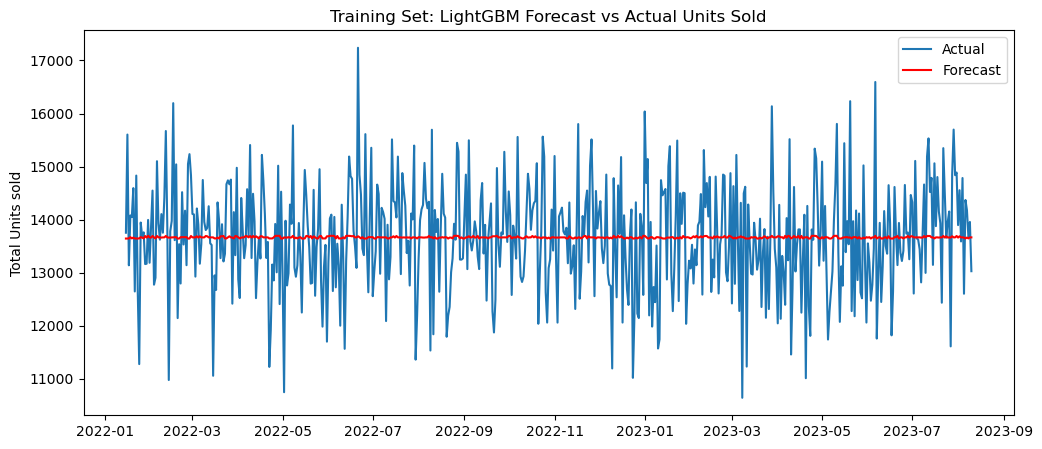

In [66]:
# Visualize unit training predictions
plt.figure(figsize=(12, 5))
plt.plot(X_train_units.index, y_train_units, label="Actual")
plt.plot(X_train_units.index, y_train_pred_units, label="Forecast", color="red")
plt.title("Training Set: LightGBM Forecast vs Actual Units Sold")
plt.ylabel("Total Units sold")
plt.legend()
plt.show()

In [67]:
# Make revenue training evaluation
y_train_pred_rev = revenue_model.predict(X_train_revenue)
training_mae = mean_absolute_error(y_train_revenue, y_train_pred_rev)
training_rmse = np.sqrt(mean_squared_error(y_train_revenue, y_train_pred_rev))

print("Revenue model training MAE:", training_mae)
print("Revenue model training RMSE:", training_rmse)

Revenue model training MAE: 36540.27919406746
Revenue model training RMSE: 46557.243361445726


Notably, the RMSE score for this model is considerably lower (about 34% lower than the base ARIMA in the previous notebook). Now, let's make a visualization of the results.

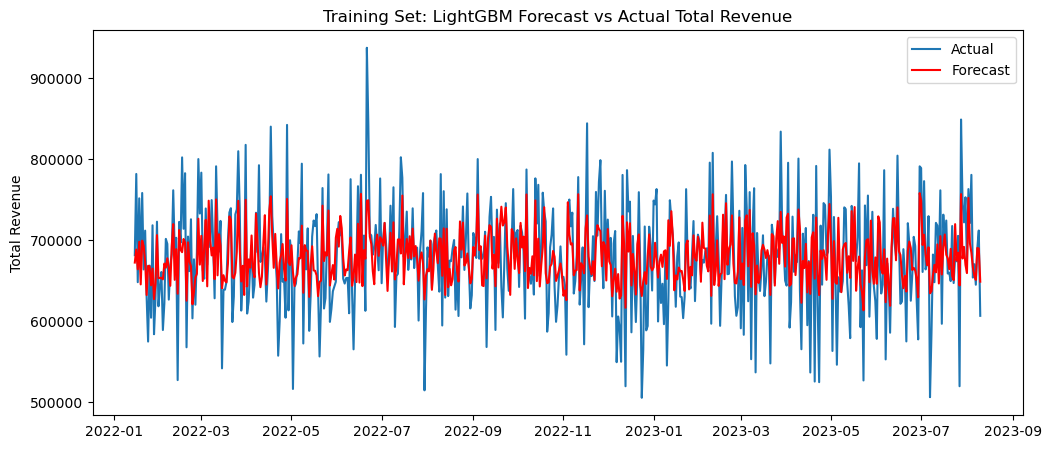

In [68]:
# Visualize revenue training predictions
plt.figure(figsize=(12, 5))
plt.plot(X_train_revenue.index, y_train_revenue, label="Actual")
plt.plot(X_train_revenue.index, y_train_pred_rev, label="Forecast", color="red")
plt.title("Training Set: LightGBM Forecast vs Actual Total Revenue")
plt.ylabel("Total Revenue")
plt.legend()
plt.show()

Now, let's evaluate on our test data

In [69]:
# Make units training evaluation
y_test_pred_units = units_model.predict(X_test_units)
test_mae = mean_absolute_error(y_test_units, y_test_pred_units)
test_rmse = np.sqrt(mean_squared_error(y_test_units, y_test_pred_units))

print("Units model test MAE:", test_mae)
print("Units model test RMSE:", test_rmse)

Units model test MAE: 854.6562016271763
Units model test RMSE: 1061.2602686099385


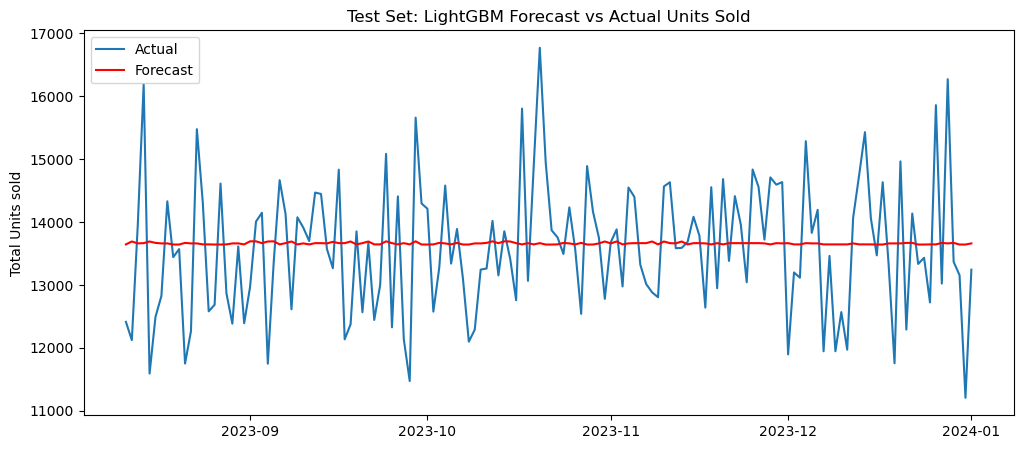

In [70]:
# Visualize unit training predictions
plt.figure(figsize=(12, 5))
plt.plot(X_test_units.index, y_test_units, label="Actual")
plt.plot(X_test_units.index, y_test_pred_units, label="Forecast", color="red")
plt.title("Test Set: LightGBM Forecast vs Actual Units Sold")
plt.ylabel("Total Units sold")
plt.legend()
plt.show()

In [71]:
# Make revenue training evaluation
y_test_pred_rev = revenue_model.predict(X_test_revenue)
test_mae = mean_absolute_error(y_test_revenue, y_test_pred_rev)
test_rmse = np.sqrt(mean_squared_error(y_test_revenue, y_test_pred_rev))

print("Revenue model test MAE:", test_mae)
print("Revenue model test RMSE:", test_rmse)

Revenue model test MAE: 48195.983973877504
Revenue model test RMSE: 62075.43484967417


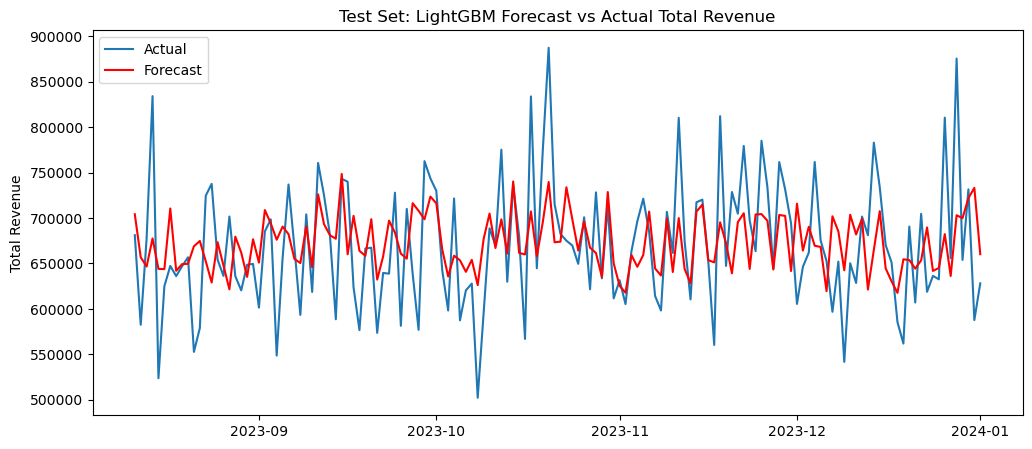

In [72]:
# Visualize revenue test predictions
plt.figure(figsize=(12, 5))
plt.plot(X_test_revenue.index, y_test_revenue, label="Actual")
plt.plot(X_test_revenue.index, y_test_pred_rev, label="Forecast", color="red")
plt.title("Test Set: LightGBM Forecast vs Actual Total Revenue")
plt.ylabel("Total Revenue")
plt.legend()
plt.show()

This notebook and its contents are intended for educational purposes only. Feel free to explore.